In [60]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1

In [61]:
import matplotlib.pyplot as plt
import numpy as np

Consider the following dataset (Petricoin et al., Lancet, 2002).

Each column of A represents measurements taken from a patient. There are 216 columns representing 216
patients, out of which 121 have ovarian cancer. Each row represents the concentration of a different protein in
the genomic signature of the patient.

In [62]:
ovariancancer_obs_path = 'data/ovariancancer_obs.csv'
ovariancancer_grp_path = 'data/ovariancancer_grp.csv'
A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose()
f = open(ovariancancer_grp_path)
grp = np.array(f.read().split("\n"))
grp = grp[grp != '']
n_features = A.shape[0]
n_patients = A.shape[1]
print('%d patients' % n_patients)
print('%d features' % n_features)

216 patients
4000 features


Implement the randomized SVD.

In [63]:
def randomized_SVD(X, k):
  _, m = X.shape[0], X.shape[1]
  G = np.random.randn(m, k) #Build the gaussian random matrix (namely G)
  Y = X @ G #Define Y as the matrix multiplication
  Q, R = np.linalg.qr(Y) #Apply the QR factorization on Y
  B = Q.T @ X #Define the matrix B
  U_Y, s, VT = np.linalg.svd(B, full_matrices = False) #Apply SVD on B
  U = Q @ U_Y #Lifting up U_Y
  return U, s, VT

Perform PCA on the data, by using the exact SVD algorithm. Then, plot the trend w.r.t. $i$ of the singular values $σ_i$.

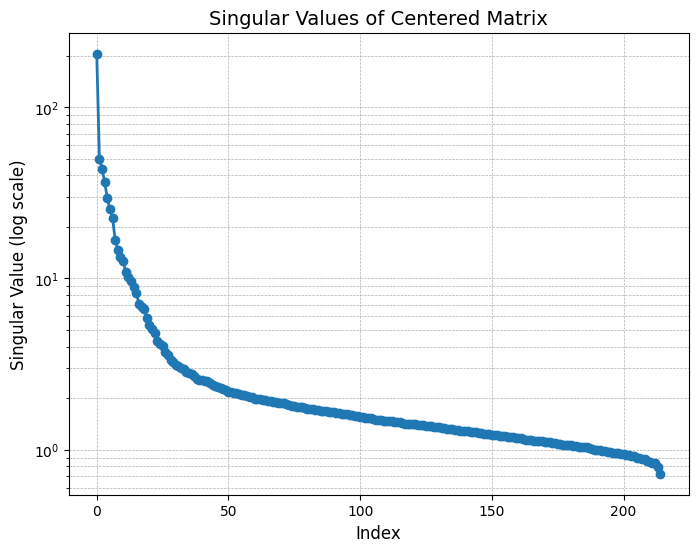

In [64]:
# Assuming A is already defined
A_mean = np.mean(A, axis=1)
A_bar = A - A_mean[:, None]
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

fig, ax = plt.subplots(figsize=(8, 6))

ax.semilogy(
    s[:-1], "o-", color="tab:blue", linewidth=2, markersize=6
)  # Remove last singular value for better visualization
ax.set_title("Singular Values of Centered Matrix", fontsize=14)
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Singular Value (log scale)", fontsize=12)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.tick_params(axis="both", which="major", labelsize=10)

Now, repeat the computation by considering the randomized SVD algorithm of rank $k = 1,5,10,50$ and $100$.

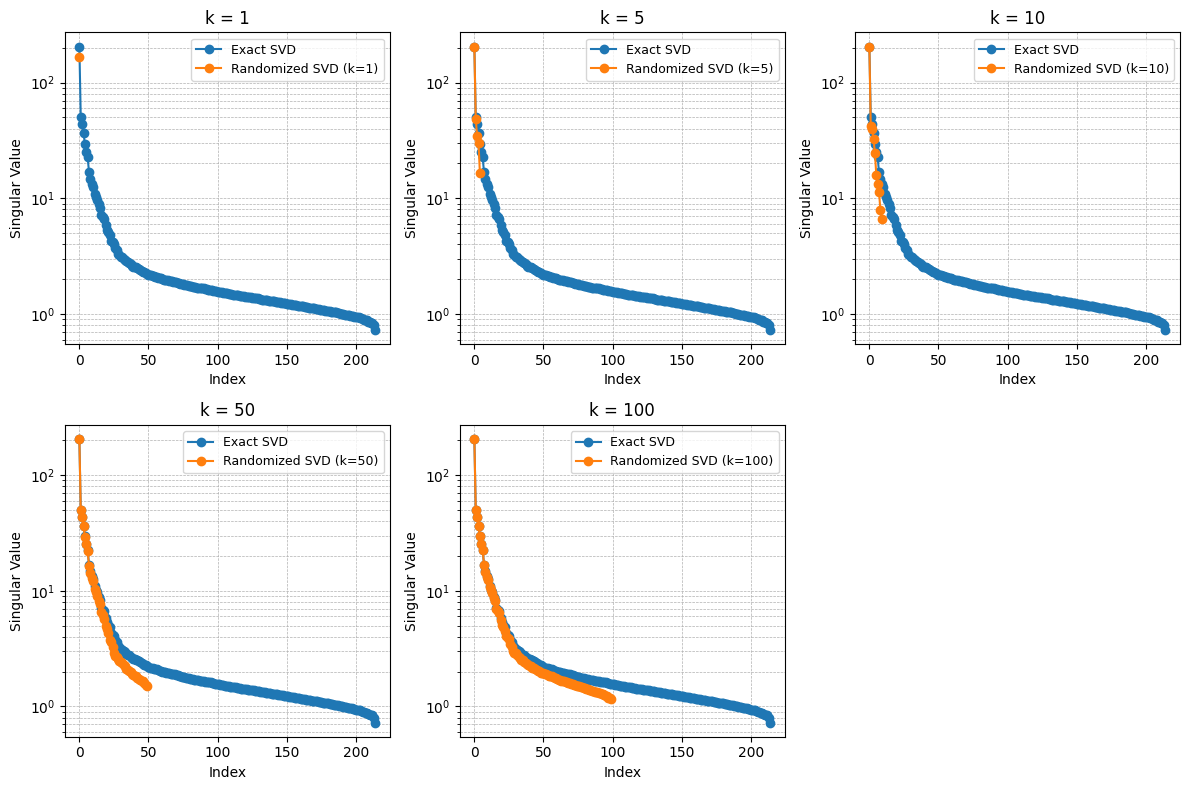

In [65]:
ks = [1, 5, 10, 50, 100]
singular_values_list = []

for k in ks:
    _, randS, _ = randomized_SVD(A_bar, k)
    singular_values_list.append(randS)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i in range(5):
    axes[i].semilogy(s[:-1], 'o-', label='Exact SVD', color='tab:blue')
    axes[i].semilogy(singular_values_list[i], 'o-', label=f'Randomized SVD (k={ks[i]})', color='tab:orange')
    axes[i].legend(fontsize=9)
    axes[i].set_title(f'k = {ks[i]}', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Singular Value')

# Hide the 6th (empty) subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

Comment what you see.

By increasing the number of k (which is the lower-dimension considered in RSVD) we obtain a better approximation of the first singular values meanwhile in the tail the approximation tends to be worst. This is one of the reason for which the idea of oversampling is introduced.

Use PCA (with exact SVD) to perform dimensionality reduction on the dataset for rank $k = 1, 5, 10, 50$ and $100$. Compute the reconstruction error of the dataset as a function of k.

In [66]:
U, s, VT = np.linalg.svd(A_bar, full_matrices = False)

recon_error = []

for k in ks:
  A_k = U[:,:k] @ np.diag(s[:k]) @ VT[:k,:]
  error = np.linalg.norm(A_bar - A_k)
  recon_error.append(error)

Repeat the same exercise by using the randomized SVD algorithm.

In [67]:
recon_error_rand = []

for k in ks:
  rU, rs, rVT = randomized_SVD(A_bar, k)
  A_k = rU @ np.diag(rs) @ rVT
  error = np.linalg.norm(A_bar - A_k)
  recon_error_rand.append(error)

Repeat the same exercise by using the randomized SVD algorithm with a +50% oversampling, that is by increasing by 50% the number of columns in the matrix random P (round the quantity 1.5 k to the closest integer).

In [68]:
def randomized_SVD_oversampling(X, k):
  _, m = X.shape[0], X.shape[1]
  G = np.random.randn(m, round(k * 1.5)) #Build the gaussian random matrix (namely G)
  Y = X @ G #Define Y as the matrix multiplication
  Q, _ = np.linalg.qr(Y) #Apply the QR factorization on Y
  B = Q.T @ X #Define the matrix B
  U_Y, s, VT = np.linalg.svd(B, full_matrices = False) #Apply SVD on B
  U = Q @ U_Y #Lifting up U_Y
  return U, s, VT

recon_error_rand_over = []

for k in ks:
  rU, rs, rVT = randomized_SVD_oversampling(A_bar, k)
  A_k = rU @ np.diag(rs) @ rVT
  error = np.linalg.norm(A_bar - A_k)
  recon_error_rand_over.append(error)

Finally, plot the trend of the reconstruction error of the dataset as a function of k in the three cases. Comment on the results.

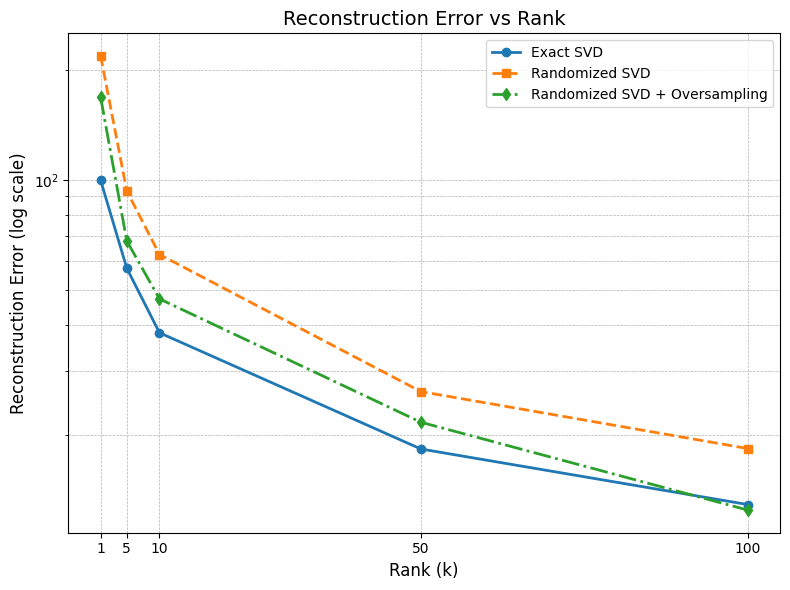

In [69]:
plt.figure(figsize=(8, 6))

plt.semilogy(ks, recon_error, "o-", label="Exact SVD", linewidth=2, markersize=6, color='tab:blue')
plt.semilogy(ks, recon_error_rand, "s--", label="Randomized SVD", linewidth=2, markersize=6, color='tab:orange')
plt.semilogy(ks, recon_error_rand_over, "d-.", label="Randomized SVD + Oversampling", linewidth=2, markersize=6, color='tab:green')

plt.title("Reconstruction Error vs Rank", fontsize=14)
plt.xlabel("Rank (k)", fontsize=12)
plt.ylabel("Reconstruction Error (log scale)", fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)
plt.xticks(ks)  # Ensure x-ticks match ks
plt.tight_layout()
plt.show()

Exact SVD gives the lowest reconstruction error for a given k; the error decreases rapidly as k increases.

Randomized SVD has slightly higher reconstruction error; for small k, randomized SVD is less precise, but still a decent low-cost approximation.

Randomized SVD + Oversampling typically performs better than standard randomized SVD; oversampling adds a few extra random vectors during the approximation, capturing more of the matrix's structure.

Make a scatterplot of the first two principal components of the patients (obtained with exact SVD), by plotting in red patients in the group ”cancer” and in blue the patients in the remaining group.

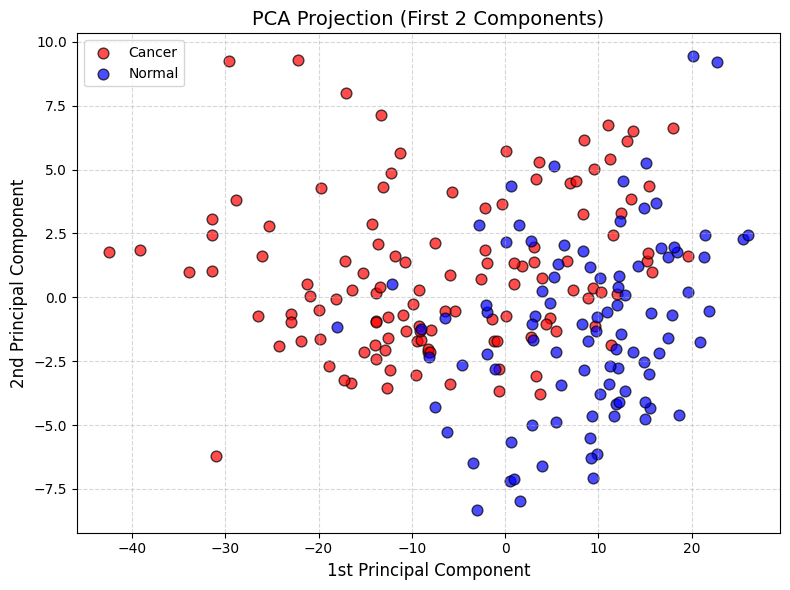

In [70]:
# Project all data onto the first two principal components (no loop needed)
projections = U[:, :2].T @ (A - A_mean[:, None])  # Shape: (2, n_patients)

# Extract x and y components
x_vals, y_vals = projections[0], projections[1]

# Create boolean masks for group labels
grp = np.array(grp)  # Ensure it's a NumPy array
mask_cancer = grp == 'Cancer'
mask_normal = grp == 'Normal'

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_vals[mask_cancer], y_vals[mask_cancer], color='red', label='Cancer', s=60, alpha=0.7, edgecolor='k')
plt.scatter(x_vals[mask_normal], y_vals[mask_normal], color='blue', label='Normal', s=60, alpha=0.7, edgecolor='k')

plt.title('PCA Projection (First 2 Components)', fontsize=14)
plt.xlabel('1st Principal Component', fontsize=12)
plt.ylabel('2nd Principal Component', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Repeat the same exercize with a rank k = 2 randomized SVD.

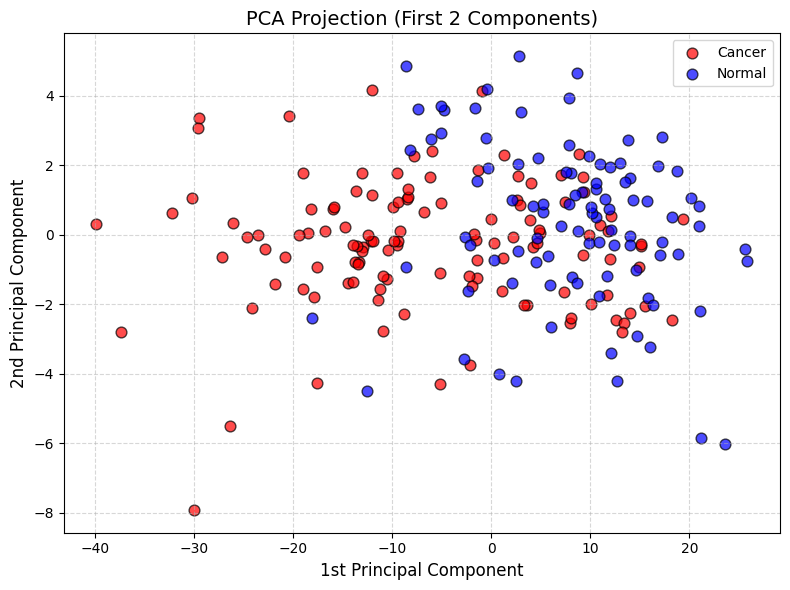

In [71]:
randU, randS, randVT = randomized_SVD(A_bar, 2)

# Project all data onto the first two principal components (no loop needed)
projections = randU[:, :2].T @ (A - A_mean[:, None])  # Shape: (2, n_patients)

# Extract x and y components
x_vals, y_vals = projections[0], projections[1]

# Create boolean masks for group labels
grp = np.array(grp)  # Ensure it's a NumPy array
mask_cancer = grp == 'Cancer'
mask_normal = grp == 'Normal'

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_vals[mask_cancer], y_vals[mask_cancer], color='red', label='Cancer', s=60, alpha=0.7, edgecolor='k')
plt.scatter(x_vals[mask_normal], y_vals[mask_normal], color='blue', label='Normal', s=60, alpha=0.7, edgecolor='k')

plt.title('PCA Projection (First 2 Components)', fontsize=14)
plt.xlabel('1st Principal Component', fontsize=12)
plt.ylabel('2nd Principal Component', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Compute the execution time needed to run the SVD algorithm in the two cases.

In [72]:
#Exact SVD
%timeit np.linalg.svd(A_bar, full_matrices=False)

182 ms ± 8.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
#Randomized SVD (k = 2)
%timeit randomized_SVD(A_bar, 2)

1.96 ms ± 148 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Comment on the results.

In terms of time of computation the randommized version of SVD is clearly much faster. We can also observe that by performing a projection into the first 2 principal components the results are not so much different: for eample if we want to build a simple classifier by considering a threshold in the first principal component we will choose $threshold=-5$ in both cases.

Then using RSVD can really help (at least in this case) in improving the computation time and we would prefer to use it.

# Exercise 2

In [74]:
import numpy as np
import jax
import jax.numpy as jnp

Consider the subset of the Quantum Physics Dataset provided by Cornell University. The goal is to learn a classification rule that differentiates between two types of particles generated in high energy collider experiments.

In [75]:
X = np.genfromtxt('data/X.dat') # Features
y = np.genfromtxt('data/y.dat') # Labels (+1, -1)
X.shape, y.shape

((10000, 46), (10000,))

Classify the data by solving the following minimization problem

$$
min_{\mathbf{w}}J(\mathbf{w}) = \frac{1}{N}\sum_iJ_i(\mathbf{w})
$$

where

$$
J_i({\mathbf{w}}) = L(\mathbf{w}^T\mathbf{x}_i, y_i)
$$

with

$$
L(s,y) = log(1+exp(-sy))
$$

In [76]:
def loss(w, X, y):
    scores = jnp.dot(X, w)  # shape: (batch_size,)
    return jnp.mean(jnp.logaddexp(0, -y * scores))  # numerically stable

Implement the Stochastic Gradient Descent algorithm (SGD) (batch size = 1) with constant learning rate equal to 0.5. Perform 5000 iterations and initialize the weight vector to zero.

In [77]:
# Data
n_training_points = X.shape[0]
# Training options
num_epochs = 5000
learning_rate_max = 0.1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
learning_rate_constant = 0.5
batch_size = 32

loss_jit = jax.jit(loss)
grad_jit = jax.jit(
    jax.grad(loss, argnums=0, allow_int=True)
)  # differentiate w.r.t. the first argument w

history = []

n_features = X.shape[1]
w = jnp.zeros(n_features)

for epoch in range(num_epochs):
    learning_rate = learning_rate_constant
    idxs = np.random.choice(n_training_points, batch_size)

    # Ensure shapes are correct (always 2D for X, 1D for y)
    X_batch = X[idxs].reshape((batch_size, -1))
    y_batch = y[idxs].reshape((batch_size,))

    grads = grad_jit(w, X_batch, y_batch)
    w = w - learning_rate * grads

    # Record full-dataset loss (not batch loss)
    history.append(loss_jit(w, X, y))

print("Final loss: %1.3e" % history[-1])

Final loss: 5.805e-01


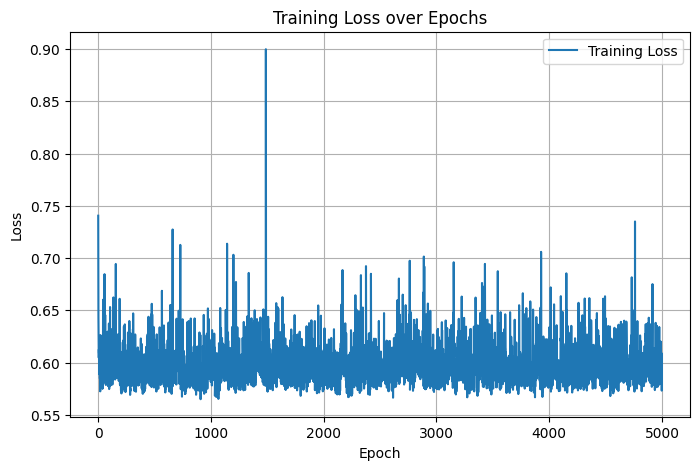

In [78]:
plt.figure(figsize=(8,5))
plt.plot(history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Repeat the minimization using the SGD with the following update for the learning rate
$$
\eta_k = \frac{\eta_0}{1+\frac{k}{100}}
$$
where k is the iteration number and $η_0 = 0.05$.

In [79]:
# Data
n_training_points = X.shape[0]
# Training options
num_epochs = 5000
learning_rate_max = 0.5e-2
learning_rate_min = 2e-2
learning_rate_decay = 100
learning_rate_constant = 0.5
batch_size = 1

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 0)) # differentiate w.r.t. the first argument w

history_adaptive = []

n_features = X.shape[1]
w = jnp.zeros(n_features)

for epoch in range(num_epochs):
  learning_rate = learning_rate_max / (1 + epoch/learning_rate_decay) # learning rate decay
  idxs = np.random.choice(n_training_points, batch_size)

  grads = grad_jit(w, X[idxs,:], y[idxs])
  w -= learning_rate * grads

  history_adaptive.append(loss_jit(w, X, y))

print('loss: %1.3e' % history_adaptive[-1])

loss: 6.005e-01


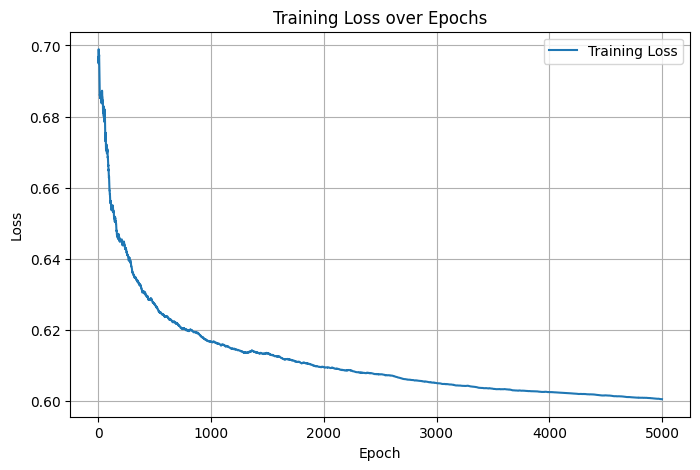

In [80]:
plt.figure(figsize=(8,5))
plt.plot(history_adaptive, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Comment the results.

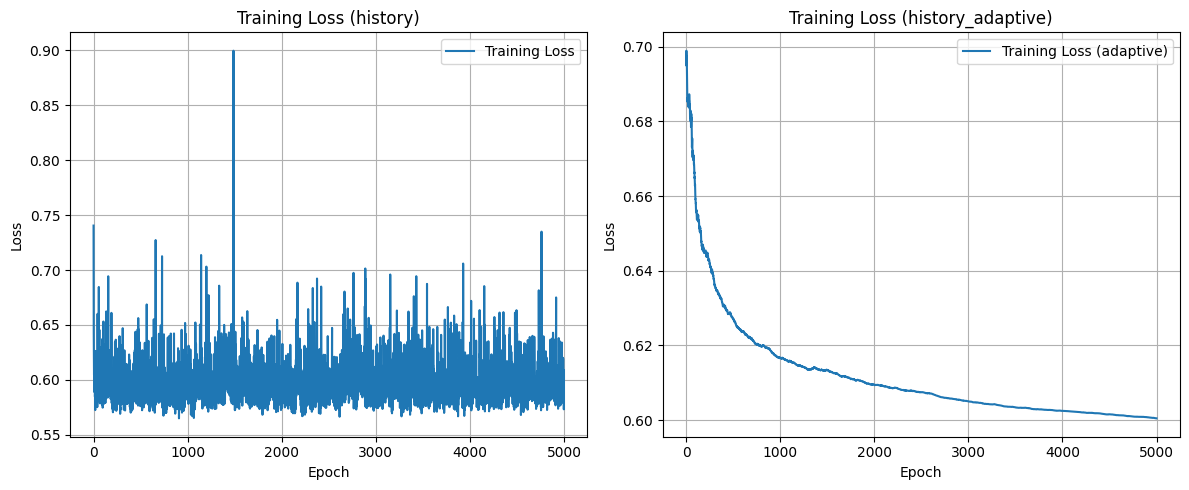

In [81]:
plt.figure(figsize=(12, 5))

# Plot 1
plt.subplot(1, 2, 1)
plt.plot(history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (history)')
plt.legend()
plt.grid(True)

# Plot 2
plt.subplot(1, 2, 2)
plt.plot(history_adaptive, label='Training Loss (adaptive)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (history_adaptive)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The fixed learning rate training is unstable because the constant step size (0.5) is too large, causing the gradient updates to overshoot the minimum and resulting in oscillations or divergence.

In contrast, the adaptive learning rate starts relatively high but gradually decreases over epochs, allowing large steps early on for faster progress and smaller steps later for stable convergence.

This controlled decay prevents overshooting and helps the model smoothly reach a minimum,making the adaptive approach much more effective and stable.